# AC 221 Final Project Notebook

In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Reading NYPD Stop, Question and Frisk Data

In [16]:
sqf_df = pd.read_csv('../data/sqf-2018.csv')
print(sqf_df.shape)
sqf_df.head()

(11008, 83)


,STOP_FRISK_ID,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SEARCH_BASIS_OTHER_FLAG,SEARCH_BASIS_OUTLINE_FLAG,DEMEANOR_CODE,DEMEANOR_OF_PERSON_STOPPED,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_PREMISES_NAME,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,(null),P,PSB,0,MENACING,18,Y,(null),Y,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,COOPERATIVE,(null),MALE,WHITE,5.1,170,MED,BRO,BLK,(null),1,G,(null),VARICK STREET && FRANKLIN STREET,(null),VARICK STREET,982327,201274,(null),PBMS,MANHATTAN
1,2,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,CPW,15,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),DE,NERVOUS,26,MALE,BLACK HISPANIC,6.1,250,HEA,BRO,BLK,(null),34,C,(null),DYCKMAN STREET && POST AVENUE,(null),DYCKMAN STREET,1004892,253548,(null),PBMN,MANHATTAN
2,3,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,GRAND LARCENY,10,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,RELIEVED,40,MALE,WHITE HISPANIC,5.5,150,THN,BRO,BLD,(null),43,B,4M,2245 RANDALL AVENUE,(null),RANDALL AVENUE,1026706,237776,(null),PBBX,BRONX
3,4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,ROBBERY,15,Y,(null),Y,Y,ROBBERY,N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),(null),(null),(null),(null),Y,Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),Y,(null),DE,COMPLAIN,38,MALE,AMERICAN INDIAN/ALASKAN NATIVE,5.1,

## Data Cleaning

In [17]:
# drop unnecessary variables
def drop_unnecessary_variables(df, variables_list):
    return df.drop(variables_list, axis=1)

# dealing with missing values
def deal_with_missing_values(df):
    return df.replace('(null)', np.nan)

# convert Y/N flag columns to boolean
def convert_flags_to_boolean(df):
    binary_map_dict = {'Y': 1, 'N': 0, np.nan: 0, 'I':1, 'S':1, 'V':1}
    
    # carrying out this operation for flags
    for col in df.columns: 
        if 'FLAG' in col:
            df[col] = list(map(lambda x: binary_map_dict[x], df[col]))
    return df
            
# convert categorical variables to one-hot-encoding
def make_one_hot(df, var):
    one_hot = pd.get_dummies(df[var])
    df = df.drop(var,axis = 1)
    df = df.join(one_hot)
    return df

# specific transformations for height: converting feet to inches
def replace_feet_inches(h):
    try:
        height = str(h).split('.')
        return int(height[0])*12 + int(height[1])
    except:
        return h
    
# specific transformations
def specific_variable_transformations(df):
    # height
    df = replace_with_function(df, 'SUSPECT_HEIGHT', replace_feet_inches)
    return df

# replaces values in a variable with a mapping
def replace_with_map(df, var, map_dict):
    df[var] = list(map(lambda x: map_dict[x], df[var]))
    return df

# replaces values in a variable with a function
def replace_with_function(df, var, function):
    df[var] = list(map(lambda x: function(x), df[var]))
    return df

In [18]:
def data_cleaning_pipeline(df):
    # carrying out data cleaning using helper functions defined above
    unnecessary_variables = ['STOP_LOCATION_PREMISES_NAME', 'STOP_FRISK_ID']
    df = drop_unnecessary_variables(df, unnecessary_variables)

    # dealing with missing values
    df = deal_with_missing_values(df)

    # convert Y/N flags to booleans and doing the same for gender
    df = convert_flags_to_boolean(df)
    df = replace_with_map(df, 'SUSPECT_SEX', {'MALE': 1, 'FEMALE': 0, np.nan: np.nan})

    # specific variable transformations
    df = specific_variable_transformations(df)

    # convert categorical variables to one-hot
    df = make_one_hot(df, 'SUSPECT_RACE_DESCRIPTION')
    df = make_one_hot(df, 'SUSPECTED_CRIME_DESCRIPTION')
    # TODO: borough, officer rank
    
    # done
    print('Cleaned dataframe shape: {}'.format(df.shape))
    return df

In [24]:
clean_sqf_df = data_cleaning_pipeline(sqf_df)
clean_sqf_df.head()

Cleaned dataframe shape: (11008, 112)


,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,...,SUSPECT_SEX,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC,ASSAULT,AUTO STRIPPIG,BURGLARY,CPSP,CPW,CRIMINAL MISCHIEF,CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,CRIMINAL POSSESSION OF FORGED INSTRUMENT,CRIMINAL POSSESSION OF MARIHUANA,CRIMINAL SALE OF CONTROLLED SUBSTANCE,CRIMINAL SALE OF MARIHUANA,CRIMINAL TRESPASS,FORCIBLE TOUCHING,GRAND LARCENY,GRAND LARCENY AUTO,MAKING GRAFFITI,MENACING,MURDER,OTHER,PETIT LARCENY,PROSTITUTION,RAPE,RECKLESS ENDANGERMENT,ROBBERY,TERRORISM,THEFT OF SERVICES,UNAUTHORIZED USE OF A VEHICLE
0,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,NaN,P,PSB,0,18,1,NaN,1,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,...,1.0,61,170,MED,BRO,BLK,NaN,1,G,NaN,VARICK STREET && FRANKLIN STREET,VARICK STREET,982327,201274,NaN,PBMS,MANHATTAN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,15,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1.0,73,250,HEA,BRO,BLK,NaN,34,C,NaN,DYCKMAN STREET && POST AVENUE,DYCKMAN STREET,1004892,253548,NaN,PBMN,MANHATTAN,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,10,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,...,1.0,65,150,THN,BRO,BLD,NaN,43,B,4M,2245 RANDALL AVENUE,RANDALL AVENUE,1026706,237776,NaN,PBBX,BRONX,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,...,1.0,61,160,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,BROOKLYN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,NaN,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,...,1.0,71,230,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,BROOKLYN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Modeling

### Model 1: Random Forest Model Using Select Features

In [25]:
model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
y = model_df['SUSPECT_ARRESTED_FLAG']
X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model_1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
model_1.score(X_test, y_test)

0.7717451523545706

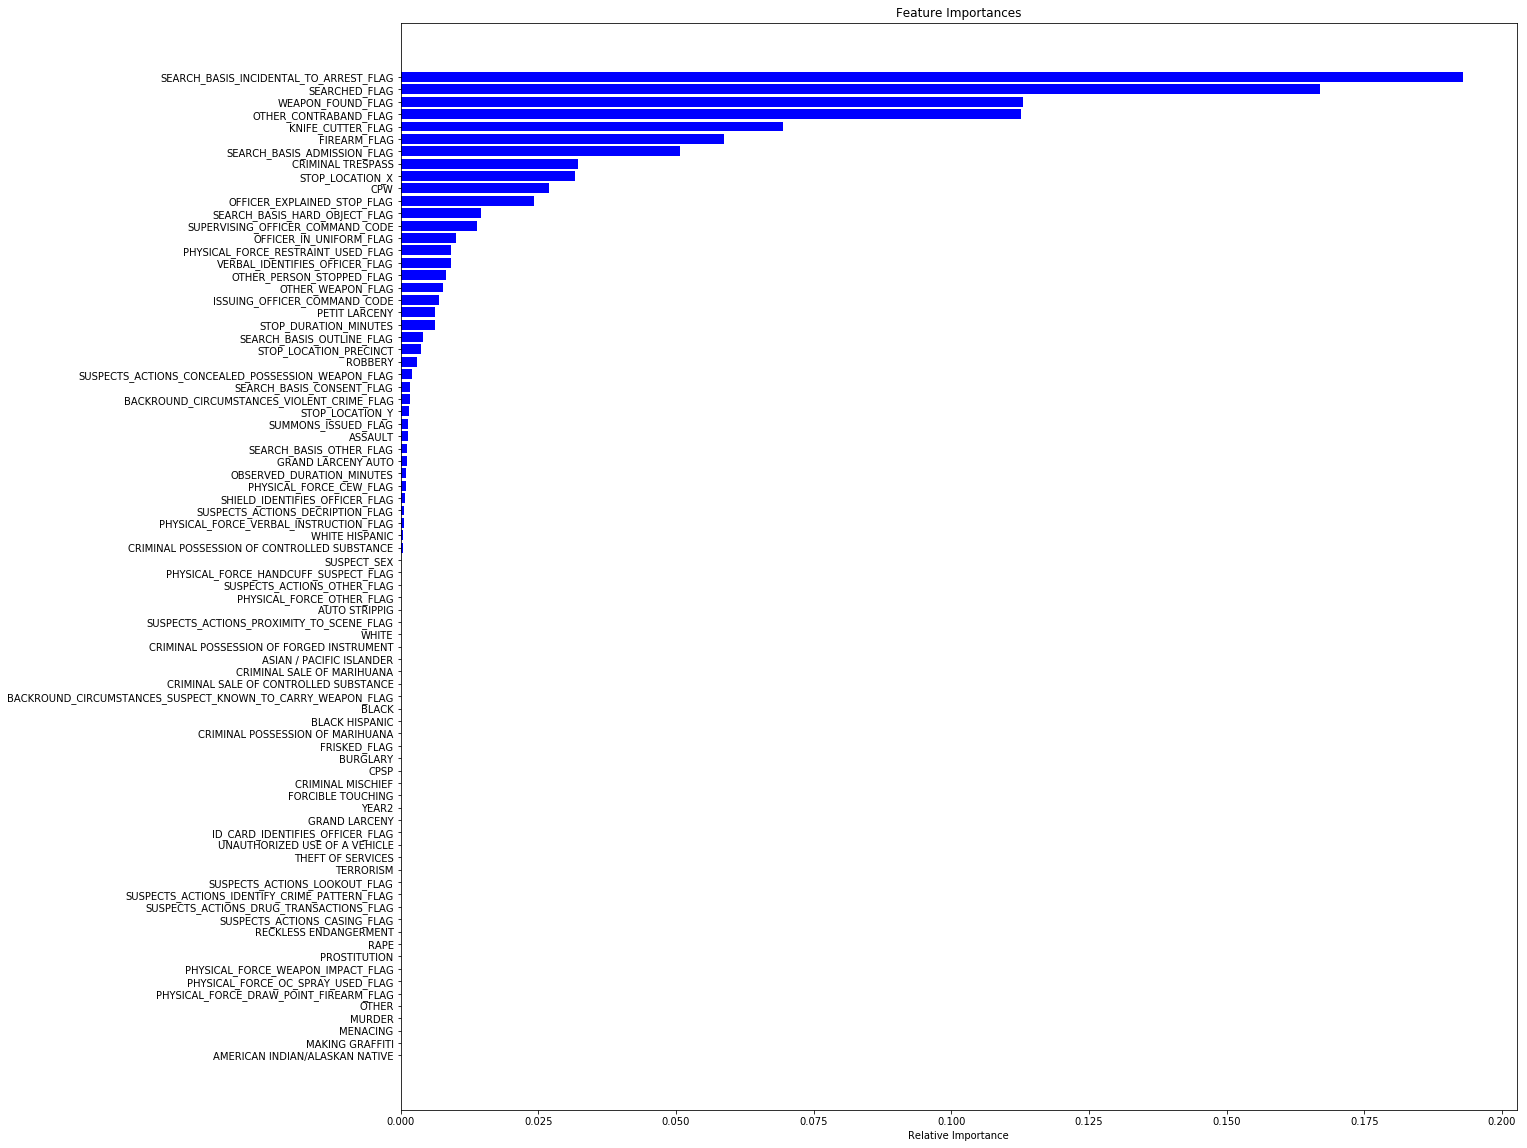

In [27]:
features = X_train.columns
importances = model_1.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(20,20))
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([features[i] for i in indices])
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Model 2: TBD

## Statistical Parity

Statistical parity measures the difference between the probability of positive decisions for the protected group and the probability of positive decisions for the unprotected group. Mathematically:
$$Sp = P(d=1|G=0) - P(d=1|G=1)$$

Ideally, $Sp$ should be small such that there is little difference of probability of positive decisionb etween protected and unprotected group. A big value of $Sp$ suggests potential unfairness in the dataset and $Sp$ of 0 suggests complete fairness (equal probability).

In our dataset, we can examine the probability of positive decision (stopped and arrested) between different **gender** and **race**.

In gender, we are comparing the proportion of positive decisions amongst male and substracting the proportion of positive decisions amongst female

$$Sp = \frac{ \text{# people with positive decision and male}} { \text{ # of male} } - \frac{ \text{# people with positive decision and female}} { \text{ # of female}}$$

In [57]:
# Statistical parity function
def evaluate_statistical_parity(predictions, protected_class_array):
    """Function to calculate statistical parity.

     Parameters
    ----------
    predictions (numpy array): binary decision labels outputted by our trained model.
    protected_class_array (numpy array): boolean mask where protected rows are marked True.

    Returns
    -------
    bias (float): statistical parity bias 
    (difference between proportion of positive decisions of protected class and unprotected class)
    """
    prop_protected = np.sum(predictions & protected_class_array) / np.sum(protected_class_array)
    prop_not_protected = np.sum(predictions & ~protected_class_array) / np.sum(~protected_class_array)
    bias = np.abs(prop_protected - prop_not_protected)

    return bias

In [20]:
parity_df = deal_with_missing_values(sqf_df)
parity_df = convert_flags_to_boolean(parity_df)
parity_df = replace_with_map(parity_df, 'SUSPECT_SEX', {'MALE': 1, 'FEMALE': 0, np.nan: np.nan})
parity_df = replace_with_map(parity_df, 'SUSPECT_RACE_DESCRIPTION', {'BLACK': 1, 'WHITE': 0, 'WHITE HISPANIC': 2, 'BLACK HISPANIC': 2, 'ASIAN / PACIFIC ISLANDER':3, 'AMERICAN INDIAN/ALASKAN NATIVE':4, np.nan: np.nan})

In [21]:
parity_df['black_white'] = parity_df['SUSPECT_RACE_DESCRIPTION']
parity_df['black_white'][parity_df['black_white'] > 1] = np.nan


/Users/pwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
test_inx = X_test.index
parity_df_test = parity_df.iloc[test_inx]

In [64]:
# print('Statistical Parity of Gender:', evaluate_statistical_parity(parity_df['SUSPECT_ARRESTED_FLAG'].values, parity_df['SUSPECT_SEX'].values.astype(int)))
thres = 0.5
predictions = model_1.predict(X_test) > thres
print('Statistical Parity of Gender:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['SUSPECT_SEX'].values.astype(int) == 0))
# Female is coded as 0
                            

Statistical Parity of Gender: 0.004538799958383501


Statistical parity shows perfect fairness when the indicator is 0. From the data, we see almost prefect fairness between the two genders that the proportion of decision on arresting is very similar between both genders.

In [66]:
# print('Statistical Parity on Black/White:', evaluate_statistical_parity(parity_df['SUSPECT_ARRESTED_FLAG'].values, 
#                             parity_df['black_white'].values.astype(int)))
                            

In [69]:
thres = 0.5
predictions = model_1.predict(X_test) > thres
print('Statistical Parity on Black/White:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['black_white'].values.astype(int) == 1))

# black is coded as 1
                            

Statistical Parity on Black/White: 0.004463501212525915


Statistical parity shows perfect fairness when the indicator is 0. From the data, we see almost prefect fairness between white and non-white that the proportion of decision on arresting is very similar between both groups.

## Conditional Parity
We want to see what happens when we look at the subgroup corresponding to race=1. Are we being fair, in terms of statistical parity, in that subgroup? Our conditional vector is very simple in this case: it just corresponds to the `race` column in our dataset. Remember, however, that we're still looking at fairness in terms of gender; we're just observing a racial subgroup.

In [71]:
# Conditional parity function
def evaluate_conditional_parity(predictions, protected_class_array, condition_array):
        """Function to calculate Conditional statistical parity.
        
         Parameters
        ----------
        predictions (numpy array): binary (decision) labels for X
        protected_class_array (numpy array): boolean array where protected rows are marked True
        condition_array (numpy array): boolean array that indicates conditional status
        
        Returns
        -------
        bias (float): conditional parity bias
        """
        
        # --------------
        # --------------
        # Your code here
        # --------------
        # --------------
        
        
        prop_protected = np.sum(predictions & condition_array & protected_class_array) / np.sum(condition_array & protected_class_array)
        prop_not_protected = np.sum(predictions & condition_array & ~protected_class_array) / np.sum(condition_array & ~protected_class_array)
        bias = np.abs(prop_protected - prop_not_protected)
        return bias

In [72]:
# Observing statistical parity on test set
protected_class_array = parity_df_test['black_white'].values.astype(int) == 1
condition_array = parity_df_test['SUSPECT_SEX'].values.astype(int) == 0
conditional_parity_orig = evaluate_conditional_parity(predictions, protected_class_array, condition_array)

print('Conditional Parity on test set, conditioned on people of race=1:', conditional_parity_orig)


Conditional Parity on Test set, conditioned on people of race=1: 0.05330330330330331


# False Positive (Negative) Error Rate Balance

The previous measures don't take into account the real labels of each observation; they only consider the predictions. The measure of fairness proposed here controls for equal poportions of false positives/false negatives in protected and unprotected classes. This measure is ideal in cases where committing mistakes disproportionately for different protected groups can bring negative outcomes.

We will again code these measures as they are rather easy to understand. The function definition below will guide you through the process.

In [ ]:
# # False positive and false negative rates
# def evaluate_false_negative_rate(predictions, protected, y):
#     """evaluate fnr

#     Parameters
#     ----------
#     predictions (numpy array): binary (decision) labels for X predicted by our model
#     protected (numpy array): boolean mask where protected rows are marked True or 1
#     y (numpy array): boolean array that marks ground truth

#     Note:
#         FNR: FN / CP where FN=(predictions==0) & (y==1) CN = (y==1)

#     Returns
#     -------
#     bias (float)
#     """

#     # --------------
#     # --------------
#     # Your code here
#     # --------------
#     # --------------
    
#     cond_pos_protected = np.sum((y==1) & protected)
#     cond_pos_not_protected = np.sum((y==1) & ~protected)
    
#     if cond_pos_protected == 0:
#         return 'No Condition Positive in Protected'
#     if cond_pos_not_protected == 0:
#         return 'No Condition Positive in Not Protected'

#     false_neg_protected = np.sum((y==1) & (predictions==0) & protected)
#     false_neg_not_protected = np.sum((y==1) & (predictions==0) & ~protected)

#     fnr_g = false_neg_protected / cond_pos_protected
#     fnr_not_g = false_neg_not_protected / cond_pos_not_protected
#     bias = np.abs(fnr_g - fnr_not_g)
    
#     return bias


# def evaluate_false_positive_rate(predictions, protected, y):
#     """evaluate fpr

#     Parameters
#     ----------
#     predictions (numpy array): binary (decision) labels for X predicted by our model
#     protected (numpy array): boolean mask where protected rows are marked True or 1
#     y (numpy array): boolean array that marks ground truth

#     Note:
#         FPR: FP / CN where FP=(predictions==1) & (y==0) CN = (y==0)

#     Returns
#     -------
#     bias (float)
#     """

#     # --------------
#     # --------------
#     # Your code here
#     # --------------
#     # --------------

#     cond_neg_protected = np.sum((y==0) & protected)
#     cond_neg_not_protected = np.sum((y==0) & ~protected)
    
#     if cond_neg_protected == 0:
#         return 'No Condition Negative in Protected'
#     if cond_neg_not_protected == 0:
#         return 'No Condition Negative in Not Protected'

#     false_pos_protected = np.sum((y==0) & predictions & protected)
#     false_pos_not_protected = np.sum((y==0) & predictions & ~protected)

#     fpr_g = false_pos_protected / cond_neg_protected
#     fpr_not_g = false_pos_not_protected / cond_neg_not_protected
#     bias = np.abs(fpr_g - fpr_not_g)
#     return bias


In [ ]:
# Test FPR and FNR
fpr = evaluate_false_positive_rate(predictions, protected_class_array, y_test)
fnr = evaluate_false_negative_rate(predictions, protected_class_array, y_test)

print('False positive rate: ',fpr)
print('False negative rate:',fnr)

## Other Fairness metrics 

We have coded and tested some basic Fairness metrics, but there are multiple other metrics that can be used, depending on the situation. Some of them are:

**Predictive parity:**
The fraction of correct positive predictions should be the same for protected and unprotected groups.
$$P(Y=1|d=1, G=m) = P(Y=1|d=1, G=f)$$


**Equalized odds:**
Applicants with a good actual credit scope and applicants with a bad actual credit
score should have a similar classification, regardless of the value of the protected class.
$$P(d=1|Y=i, G=m) = P(d=1|Y=i, G=f), i\in \{0,1\}$$


**Overall accuracy equality:**
Both protected and unprotected groups have equal prediction accuracy.
$$P(d=Y, G=m) = P(d=Y, G=f)$$


**Treatment Equality:**
Looks at ratio of errors a classifier makes instead of its accuracy. Satisfied if both protected and unprotected groups have equal ratio of false negatives and false positives.


We will not go through all of them in code to save time. We will now try to generate a fair model.

## Fairness Analysis

---